In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime
from scipy.stats import multivariate_normal
pd.options.display.max_columns=100

In [2]:
df = pd.read_csv('owid-covid-data.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df_russia = df[(df['location'] == 'Russia') & (df['date'] >= '2020-03-03')]
df_russia = df_russia.set_index('date').sort_index()

# Часть 2

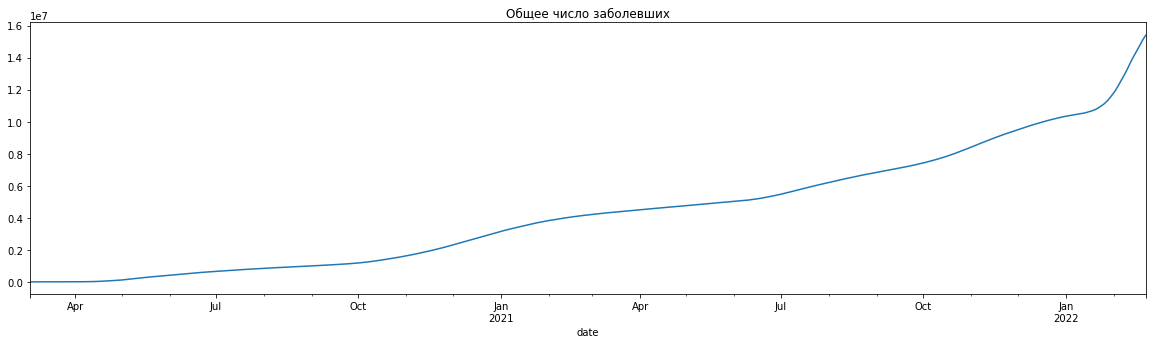

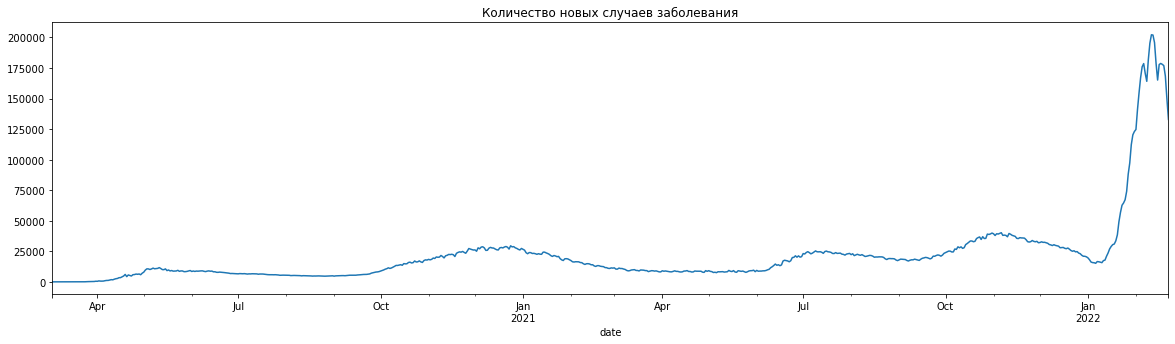

In [5]:
# график целевых переменных
df_russia['total_cases'].plot(figsize=(20, 5))
plt.title('Общее число заболевших')
plt.show()

df_russia['new_cases'].plot(figsize=(20, 5))
plt.title('Количество новых случаев заболевания')
plt.show()

In [6]:
# добавим номер дня, отберем данные на обучение
df_russia['day_num'] = range(0, df_russia.shape[0])
df_russia['new_cases'] = df_russia['new_cases'].replace(0, 1)
train_set = df_russia.iloc[:50, :]

## 2a

In [7]:
# сделаю перобразование y 
X_train = train_set['day_num'].values
y_train_log = np.log(train_set['total_cases'].values)

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train.reshape(-1, 1), y_train_log)
train_preds = lin_reg.predict(X_train.reshape(-1, 1))

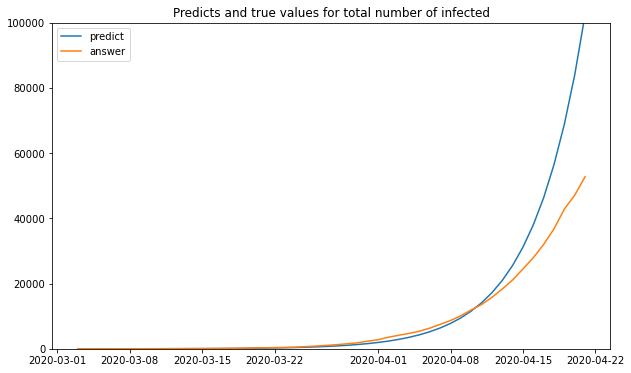

In [9]:
# посмотрю на графкие предикты линейной регресси и правильные ответы
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, np.exp(train_preds), label='predict')
plt.plot(train_set.index, train_set['total_cases'], label='answer')
plt.legend()
plt.title('Predicts and true values for total number of infected')
ax = plt.gca()
ax.set_ylim([0, 1e5])
plt.show()

In [10]:
variance = mean_squared_error(y_train_log, train_preds)
variance

0.12183046154391232

## 2b

In [11]:
# априорное распредение - гауссовское, широту буду обеспечивать большой константой, на которую умножу матрицу ковариации
sigma0 = 2500 * np.eye(2)
mu0 = np.zeros(2)

In [12]:
def bayesian(X_train, y_train, mu0, sigma0, variance):
    x_mat = np.column_stack([np.ones(X_train.shape[0]), X_train])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma0) + (1 / variance) * np.dot(x_mat.T, x_mat))
    mu_n = sigma_n.dot(np.linalg.inv(sigma0).dot(mu0) + (1 / variance) * np.dot(x_mat.T, y_train))
    return mu_n, sigma_n

In [13]:
mu_n, sigma_n = bayesian(X_train, y_train_log, mu0, sigma0, variance)

In [14]:
# параметры апостериорного распределения:
mu_n, sigma_n 

(array([1.82073028, 0.19829112]),
 array([[ 9.45974119e-03, -2.86658823e-04],
        [-2.86658823e-04,  1.17003715e-05]]))

## 2c

In [15]:
weights = np.random.multivariate_normal(mu_n, sigma_n, 1000)
preds = np.array([np.exp([w[1] * X_train + w[0]]) for w in weights])

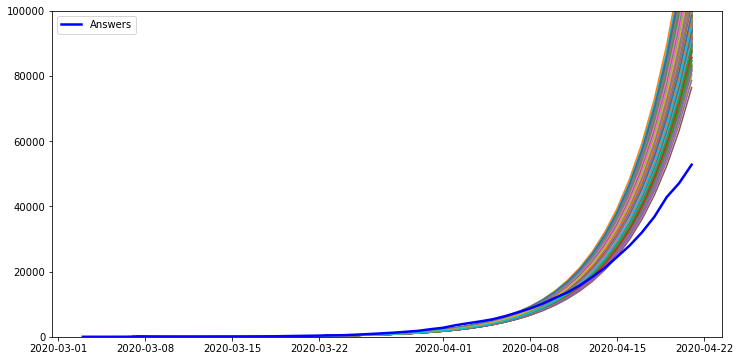

In [16]:
plt.figure(figsize=(12, 6))
for ind in range(len(preds)):
    plt.plot(train_set.index, preds[ind][0])
plt.plot(train_set.index, train_set['total_cases'].values, color='blue', linewidth=2.5, label='Answers')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 1e5])
plt.show()

In [17]:
# предикты для 1 мая, 1 июня и 1 сентября
start = datetime.date(2020, 3, 3)
end = [datetime.date(2020, 5, 1), datetime.date(2020, 6, 1), datetime.date(2020, 9, 1)]
delta_days = np.array([(end_date - start).days for end_date in end])

preds_may = np.array([np.exp([w[1] * delta_days[0] + w[0]]) for w in weights])
preds_june = np.array([np.exp([w[1] * delta_days[1] + w[0]]) for w in weights])
preds_sept = np.array([np.exp([w[1] * delta_days[-1] + w[0]]) for w in weights])

In [18]:
print(f"""Прогнозное {preds_may.mean().round(0)} и реальное {df_russia.loc['2020-05-01', 'total_cases']} \
число заболевших к 1 мая""")

print(f"""Прогнозное {preds_june.mean().round(0)} и реальное {df_russia.loc['2020-06-01', 'total_cases']} \
число заболевших к 1 июня""")

print(f"""Прогнозное {preds_sept.mean().round(0)} и реальное {df_russia.loc['2020-09-01', 'total_cases']} \
число заболевших к 1 сентября""")

Прогнозное 751837.0 и реальное 114431.0 число заболевших к 1 мая
Прогнозное 356973874.0 и реальное 414328.0 число заболевших к 1 июня
Прогнозное 3.3245764100630796e+16 и реальное 997072.0 число заболевших к 1 сентября


# 3

## 3a

- для ухода от интеграла, нужна производная
- производная от общего числа заболевших (total_cases) равна числу новых заболевших в день (new_cases)
- от экспоненты можно уйти с помощью логарифма
- возьму функцию a0x^2 + a1x + a2
- общий вид будет ln(y) = a0x^2 + a1x + a2, где y-new_cases

In [19]:
# для ухода от интеграла, нужна производная
df_russia['day_num_squared'] = df_russia['day_num']**2
X_train = df_russia.iloc[:50, :][['day_num', 'day_num_squared']].values
y_train_log = np.log(df_russia.iloc[:50, :]['new_cases'].values)

## 3b

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)
train_preds = lin_reg.predict(X_train)

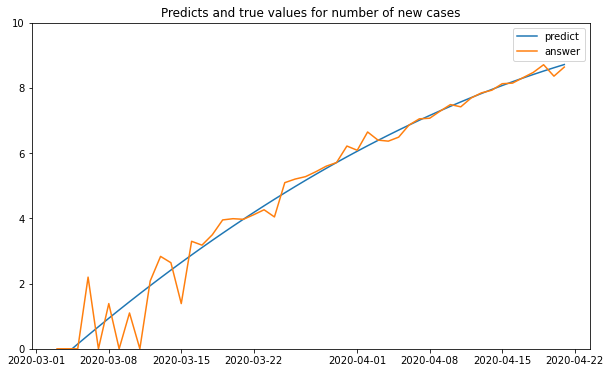

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_preds, label='predict')
plt.plot(train_set.index, y_train_log, label='answer')
plt.legend()
plt.title('Predicts and true values for number of new cases')
ax = plt.gca()
ax.set_ylim([0, 1e1])
plt.show()

In [22]:
variance = mean_squared_error(y_train_log, train_preds)
variance

0.23928684127005562

In [23]:
sigma0 = 100 * np.eye(3)
mu0 = np.zeros(3)

In [24]:
mu_n, sigma_n = bayesian(X_train, y_train_log, mu0, sigma0, variance)

In [25]:
mu_n, sigma_n

(array([-0.39642376,  0.27560911, -0.00182956]),
 array([[ 3.97858000e-02, -3.21446447e-03,  5.41155378e-05],
        [-3.21446447e-03,  3.54467031e-04, -6.76539758e-06],
        [ 5.41155378e-05, -6.76539758e-06,  1.38075588e-07]]))

## 3c

In [26]:
weights = np.random.multivariate_normal(mu_n, sigma_n, 1000)
preds = np.array([np.exp([w[2] * X_train[:, 1] + w[1] * X_train[:, 0] + w[0]]) for w in weights])

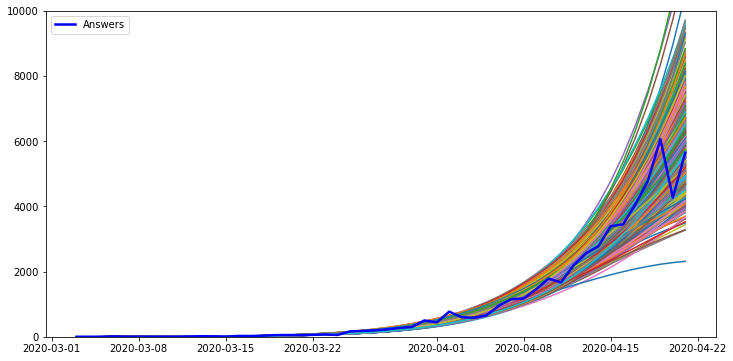

In [27]:
plt.figure(figsize=(12, 6))
for ind in range(len(preds)):
    plt.plot(train_set.index, preds[ind][0])
plt.plot(train_set.index, train_set['new_cases'].values, color='blue', linewidth=2.5, label='Answers')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 1e4])
plt.show()

In [28]:
# добавлю больше точек на график, чтобы увидеть на нем насыщение 
X_train = df_russia.iloc[:200, :][['day_num', 'day_num_squared']].values
y_train = df_russia.iloc[:200, :]['new_cases'].values

In [29]:
preds = np.array([np.exp([w[2] * X_train[:, 1] + w[1] * X_train[:, 0] + w[0]]) for w in weights])

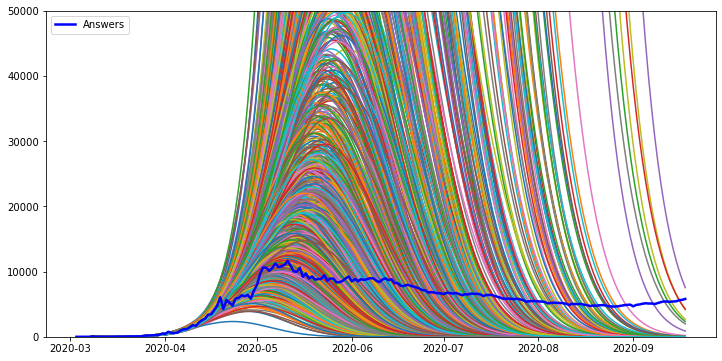

In [30]:
plt.figure(figsize=(12, 6))
for ind in range(len(preds)):
    plt.plot(df_russia.index[:200], preds[ind][0])
plt.plot(df_russia.index[:200], y_train, color='blue', linewidth=2.5, label='Answers')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 5e4])
plt.show()

In [31]:
preds_may = np.array([np.exp([w[2] * delta_days[0]**2 + w[1] * delta_days[0] + w[0]]) for w in weights])
preds_june = np.array([np.exp([w[2] * delta_days[1]**2 + w[1] * delta_days[1] + w[0]]) for w in weights])
preds_sept = np.array([np.exp([w[2] * delta_days[-1]**2 + w[1] * delta_days[-1] + w[0]]) for w in weights])

# пессимистичный прогноз
np.quantile(preds_may, 0.9, axis=0)


print(f"""Прогнозное {np.quantile(preds_may, 0.9).round(0)} и реальное {df_russia.loc['2020-05-01', 'new_cases']} \
число новых кейсов к 1 мая""")

print(f"""Прогнозное {np.quantile(preds_june, 0.9).round(0)} и реальное {df_russia.loc['2020-06-01', 'new_cases']} \
число новых кейсов к 1 июня""")

print(f"""Прогнозное {np.quantile(preds_sept, 0.9).round(0)} и реальное {df_russia.loc['2020-09-01', 'new_cases']} \
число новых кейсов к 1 сентября""")

Прогнозное 21966.0 и реальное 7933.0 число новых кейсов к 1 мая
Прогнозное 97508.0 и реальное 8485.0 число новых кейсов к 1 июня
Прогнозное 2.0 и реальное 4670.0 число новых кейсов к 1 сентября


In [32]:
# оптимистичный прогноз
print(f"""Прогнозное {np.quantile(preds_may, 0.1).round(0)} и реальное {df_russia.loc['2020-05-01', 'new_cases']} \
число новых кейсов к 1 мая""")

print(f"""Прогнозное {np.quantile(preds_june, 0.1).round(0)} и реальное {df_russia.loc['2020-06-01', 'new_cases']} \
число новых кейсов к 1 июня""")

print(f"""Прогнозное {np.quantile(preds_sept, 0.1).round(0)} и реальное {df_russia.loc['2020-09-01', 'new_cases']} \
число новых кейсов к 1 сентября""")

Прогнозное 7918.0 и реальное 7933.0 число новых кейсов к 1 мая
Прогнозное 2048.0 и реальное 8485.0 число новых кейсов к 1 июня
Прогнозное 0.0 и реальное 4670.0 число новых кейсов к 1 сентября


In [33]:
# посмотрю на все случаи коронавируса
last_total = df_russia['total_cases'][-1]
preds_all = []

for w in weights:
    preds_all.append(sum(np.exp(w[2] * df_russia['day_num_squared'].values + \
                                w[1] * df_russia['day_num'].values + w[0])))

In [34]:
print(f"""Пессимистичный прогноз по общему числу заболевших {np.quantile(preds_all, 0.9).round(0)} 
и реальное значение {last_total}""")
print(f"""Оптимистичный прогноз по общему числу заболевших {np.quantile(preds_all, 0.1).round(0)} 
и реальное значение {last_total}""")

Пессимистичный прогноз по общему числу заболевших 4720676.0 и реальное значение 15430540.0
Оптимистичный прогноз по общему числу заболевших 326118.0 и реальное значение 15430540.0


- распространение ковида плохо моделируется опробованными методами
- видно, что после насыщения сигмоиды она прогнозирует сильно меньше кейсов, чем их было на самом деле, как для оптимистичного, так и для пессимистичного сценария
- наверняка, проблемы с качеством моделирования связаны с тем, что на распространение вируса влияет большее количество факторов, чем номер дня
- я бы ориентировалась на пессимистичный прогноз на коротком горизонте в начале эпидемии и вводила карантин весной 2020, руководствуясь чисто практическими соображениями - в начале эпидемии не ясна схема лечения и не готова медицинская система